In [59]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk.stem
from nltk.stem.porter import *
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [29]:
column_names=['Sentiment','id','Time','Query','Username','Tweet']
df = pd.read_csv('/run/media/pranj/Asus/KaggleDatasets/training.1600000.processed.noemoticon.csv',names=column_names, encoding='ISO-8859-1')


In [30]:
df.drop(columns=['id','Time','Query','Username'],inplace=True)
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [31]:
new_df=df.sample(50000,random_state=42)
new_df.head()

,Sentiment,Tweet
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


## START PREPROCESSING 

In [32]:
#remove @ 
#remove links 
#remove names
#removes punctuations
#convert to all lowercase
#stopword removal
#removing numbers
#stemming 
#removing emoji (replace them by their text description)



In [33]:
import re
stop_words=set(stopwords.words('english'))
stemmer=PorterStemmer()
def preprocess(text_data):
    # Convert to lowercase
    text = text_data.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs/links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove @mentions
    text = re.sub(r'@\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Correcting spellings
    # text = str(TextBlob(text).correct()) #taking too much time

    # Removing stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Stemming 
    text = [stemmer.stem(word) for word in text.split()]
    # text = ' '.join(stem)
    return text

In [34]:
new_df['cleaned_text']=new_df['Tweet'].apply(preprocess)
new_df[['Tweet','cleaned_text']]

,Tweet,cleaned_text
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[ahhh, hope, ok]"
750,"@misstoriblack cool , i have no tweet apps fo...","[cool, tweet, app, razr]"
766711,@TiannaChaos i know just family drama. its la...,"[know, famili, drama, lamehey, next, time, u, ..."
285055,School email won't open and I have geography ...,"[school, email, wont, open, geographi, stuff, ..."
705995,upper airways problem,"[upper, airway, problem]"
...,...,...
199266,On the way home. Tired. I don't wanna babysit,"[way, home, tire, dont, wanna, babysit]"
210814,Well that was ten sneezes in a row. My allergi...,"[well, ten, sneez, row, allergi, make, day, ea..."
180674,can't go out tonight car is acting funny wat...,"[cant, go, tonight, car, act, funni, wat, shall]"
364859,Headacheeeee,[headacheeee]


#### EDA

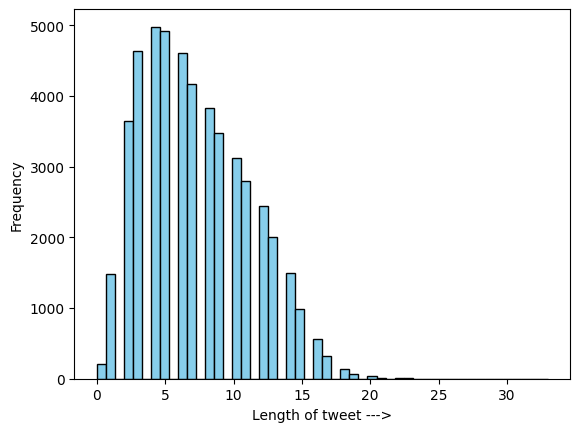

In [35]:
new_df["tweet_length"]=new_df["cleaned_text"].apply(lambda x:len(x))
plt.hist(new_df["tweet_length"],bins=50,color="skyblue",edgecolor="black")
plt.xlabel("Length of tweet --->")
plt.ylabel("Frequency")
plt.show()

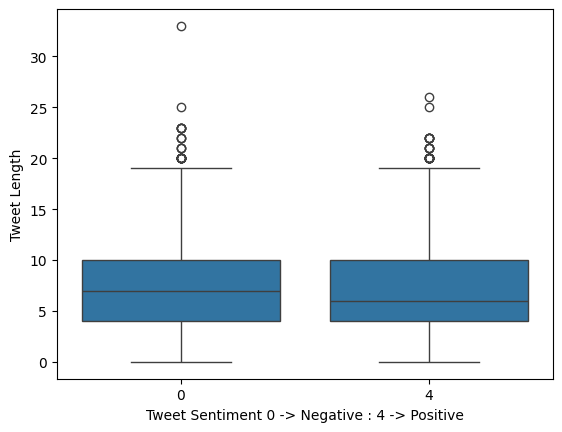

In [36]:
sns.boxplot(x=new_df['Sentiment'],y=new_df['tweet_length'])
plt.xlabel('Tweet Sentiment 0 -> Negative : 4 -> Positive')
plt.ylabel('Tweet Length')
plt.show()

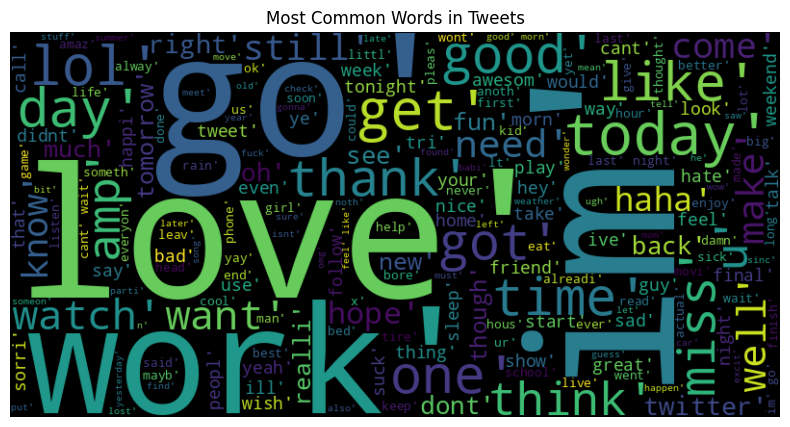

In [37]:
all_words = " ".join(new_df["cleaned_text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Tweets")
plt.show()


In [38]:
# Spacy
new_df.head()

,Sentiment,Tweet,cleaned_text,tweet_length
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[ahhh, hope, ok]",3
750,0,"@misstoriblack cool , i have no tweet apps fo...","[cool, tweet, app, razr]",4
766711,0,@TiannaChaos i know just family drama. its la...,"[know, famili, drama, lamehey, next, time, u, ...",18
285055,0,School email won't open and I have geography ...,"[school, email, wont, open, geographi, stuff, ...",9
705995,0,upper airways problem,"[upper, airway, problem]",3


In [41]:
def list_to_string(df,column_name):
    df[column_name]=df[column_name].apply(lambda x:" ".join(x) if isinstance(x,list) else str(x))
    return df
new_df=list_to_string(new_df,"cleaned_text")

In [47]:
import spacy
nlp=spacy.load("en_core_web_sm")
# new_df["Tokenized word"]=new_df["cleaned_text"].apply(lambda x:[token.text for token in nlp(x)])

In [51]:
texts=new_df["cleaned_text"].tolist()
docs=list(nlp.pipe(texts,batch_size=500,disable=["ner","parser"],n_process=-1))
new_df["Tokenized word"]=[[token.text for token in doc if token.is_alpha] for doc in docs]

In [52]:
new_df["Tokenized word"].head()

541200                                     [ahhh, hope, ok]
750                                [cool, tweet, app, razr]
766711    [know, famili, drama, lamehey, next, time, u, ...
285055    [school, email, wo, nt, open, geographi, stuff...
705995                             [upper, airway, problem]
Name: Tokenized word, dtype: object

In [60]:
w2v_model=Word2Vec(sentences=new_df["Tokenized word"],vector_size=100,window=5,min_count=5,workers=4)
def get_w2v_vectors(tokens):
    return [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]

new_df["word2vec_vectors"]=new_df["Tokenized word"].apply(get_w2v_vectors)